In [40]:
# imports and settings
from pandas import DataFrame, melt
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot settings
sns.set_style('white')
plt.rcParams['figure.dpi'] = 100

# Build a NN to classify 3's and 7's in the MNIST Dataset

The MNIST dataset is large collection of hanwritten digits, 0--9, represented as 28x28 grayscale images with values ranging from 0 (black) to 255 (white).

We're going to:

0.  Download and prepare the data.  Since we only want to use 3's and 7's for our first attempt we'll need to filter out the unnecessary digits.

1.  Create our NN model.

2.  Build the PyTorch Dataset and Dataloader.

3.  Train the model.

4.  Visualize the results.

## Step 0 - Download and Prepare the Data

This will take just a few seconds the first time you run this cell in a session:

In [41]:
mnist_train = MNIST(root='./data', train = True, download = True, transform = None)
mnist_valid = MNIST(root='./data', train = False, download = True, transform = None)

If we look at `mnist_train` we'll see a summary of the dataset:

In [42]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

This is already a PyTorch Dataset but since we're only interested in 3's and 7's we'll extract the data and filter out the unnecessary digits and build our own Datset.

The grayscale image data is stored in the `.data` attribute while the targets are stored in the `.targets` attribute.

Let's look at a few of the targets first:

In [43]:
mnist_train.targets[:20]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])

The values for each target correspond exactly to the digit in the image.  Let's look at the eigth image which should be a three:

In [44]:
image3 = mnist_train.data[27]
image3.shape

torch.Size([28, 28])

Let's have a peek at the raw data in this tensor:

In [45]:
image3

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9,  80, 207, 255,
         254, 254, 254,  97,  80,  80,  44,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  39, 15

Here is a nice visualization using a Pandas DataFrame.  This requires matplotlib as well.

In [46]:
df = DataFrame(image3[4:22,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,9,80,207,255,254,254,254,97,80,80,44,0
2,0,0,39,158,158,158,168,253,253,253,253,253,253,253,253,253,210,38
3,0,0,226,253,253,253,253,253,253,253,253,253,253,253,253,253,253,241
4,0,0,139,253,253,253,238,113,215,253,253,253,253,253,253,253,253,253
5,0,0,39,34,34,34,30,0,31,148,34,204,235,253,253,253,253,253
6,0,0,91,0,0,0,0,0,0,0,0,35,199,253,253,253,253,244
7,0,0,0,0,0,0,0,11,33,202,202,216,253,253,253,253,241,89
8,0,0,0,0,0,0,11,167,253,253,253,253,253,253,253,238,82,0
9,0,0,0,0,0,0,27,253,253,253,253,253,253,253,253,96,0,0


`matplotlib.pyplot` can be used for a similar visualization (we'll be using `imshow` frequently)

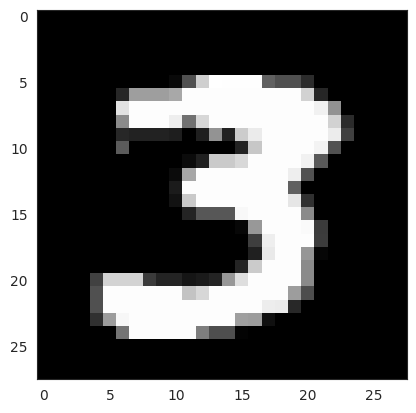

In [47]:
plt.imshow(image3,cmap = 'gray');

It doesn't look so great when it's scaled large like this, but if we convert it to a PIL image and display it, then it looks like a 3:

In [48]:
transform_pil = ToPILImage() # instantiate transform
image3_pil = transform_pil(image3)
image3_pil

### Preparing the Data

We'll start with the training data.  

1. Extract the tensors containing the inputs and targets from the downloaded PyTorch Dataset and get their shapes so we know what we're dealing with.  We'll initially work with just the training set.

In [49]:
inputs = mnist_train.data
targets = mnist_train.targets
print(inputs.shape)
print(targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


2.  Create a tensor of booleans that is True if the target is a 3 or a 7 and False otherwise.  We're going to use this tensor as an index set to extract the inputs and targets we want.  A boolean index set is often called a **mask**.

In [50]:
mask = torch.logical_or( targets == 3, targets == 7)
mask[:20]

tensor([False, False, False, False, False, False, False,  True, False, False,
         True, False,  True, False, False,  True, False, False, False, False])

3.  Use the mask to filter the inputs and targets.

In [51]:
inputs = inputs[mask]
targets = targets[mask]

4. Make the targets into 0's and 1's (as floats).  Use a 1 for the threes:

In [52]:
targets = (targets==3).float()
targets[:20]

tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 0.])

5.  Flatten the 2D inputs (the images) into 1D tensors:

In [53]:
inputs = torch.flatten(inputs, start_dim=1, end_dim=-1)
inputs.shape

torch.Size([12396, 784])

6.  Normalize the input values to be between 0 and 1:

In [54]:
inputs = inputs/255

7.  Put these steps into a function to make it easy to apply both the training and validation sets.  Your function should have inputs and targets as arguments and return the prepared inputs and targets.

In [55]:
def filter_convert_37( inputs, targets):

    # find the 3's and 7's
    mask = torch.logical_or( targets == 3, targets ==7 )

    # filter to just 3's and 7's
    inputs = inputs[mask]
    targets = targets[mask]

    # turn the targets into 0's for 7's and 1's for 3's
    targets = (targets==3).float()

    # flatten each image to a 28*28 = 784 tensor and normalize it
    inputs = torch.flatten(inputs, start_dim=1, end_dim=-1)/255

    return inputs, targets

8.  Apply your function to `mnist_train.data` and `mnist_train.targets` to get `X_train` and `y_train`.  Do the same with `mnist_valid`.  Finally print out the shapes of the prepared inputs and targets to check that everything seem reasonable.

In [56]:
X_train, y_train = filter_convert_37( mnist_train.data, mnist_train.targets)
X_valid, y_valid = filter_convert_37( mnist_valid.data, mnist_valid.targets)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

torch.Size([12396, 784])
torch.Size([12396])
torch.Size([2038, 784])
torch.Size([2038])


**Exercise**. Figure out how many 3's and 7's there are in each of the datasets.

In [57]:
num3_train = sum(y_train).long().item()
num7_train = len(y_train) - num3_train
num3_valid = sum(y_valid).long().item()
num7_valid = len(y_valid) - num3_valid
print(f'The training set has {num3_train} threes and {num7_train} sevens \n')
print(f'The validation set has {num3_valid} threes and {num7_valid} sevens')

The training set has 6131 threes and 6265 sevens 

The validation set has 1010 threes and 1028 sevens


Now the data is set up similarly to how we had it in the Logistic Regression notebook.  Instead of having points in two dimensions each digit is represented by a point in 784 dimensions.  The samples are also larger:  12396 digits in the training set and 2038 digits in the validation set.

## Step 1 - Build a Simple NN in Pytorch

Use the NN in the Logistic Regression Notebook (most recent version) as a starting point and build NN with the following specifications:

* Input Layer: 784 inputs
* Hidden Layer: 30 neurons + ReLU activation
* Output Layer: map the 30 outputs of the hidden layer to a single output and apply a sigmoid activation

In [58]:
class MNIST37(nn.Module):
    '''
    This is a simple classification network with a single hidden layer.
    '''
    def __init__(self, nInputs, nHidden, nOutputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInputs, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutputs),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return(self.layers(x))

In [59]:
nInputs = 784
nHidden = 30
nOutputs = 1
model = MNIST37(nInputs, nHidden, nOutputs).to(device)
model

MNIST37(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Let's check the model on a single input, to see if it works as expected:

In [60]:
input = X_train[0].to(device)
output = model( input )
input.shape, output.shape

(torch.Size([784]), torch.Size([1]))

## Step 2 - Datasets and Dataloaders

Follow along with the Logistic Regression notebook (most recent version) to build training and validation Datasets and Dataloaders.

In [61]:
class RegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float().unsqueeze(-1)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.y[idx])

# instantiate Dataset object for current training data
dset_train = RegressionData(X_train, y_train)
dset_valid = RegressionData(X_valid, y_valid)

<ipython-input-61-959e5b548b69>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X).float()
<ipython-input-61-959e5b548b69>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y).float().unsqueeze(-1)


In [62]:
# instantiate DataLoader
train_dataloader = DataLoader(dset_train, batch_size=4 , shuffle=True)
inputs, targets = next(iter(train_dataloader))
print(inputs)
print(inputs.shape)
print(targets)
print(targets.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([4, 784])
tensor([[0.],
        [0.],
        [1.],
        [0.]])
torch.Size([4, 1])


## Step 3 - Train the model

Use the training loop from the Logistic Regression notebook to train our 3's and 7's MNIST predictor model.  You'll likely need to experiment with the total number of epochs, the learning rate, and the batch size.  

What kind of accuracy can you get on the validation set?

In [63]:
##################################################
## training the model
##################################################

epochs = 20
outputInterval = 1
learningRate = 0.1
batchSize = 600
nInputs = 784
nHidden = 30
nOutputs = 1

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(40)
model = MNIST37(nInputs, nHidden, nOutputs).to(device)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(dset_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Initialize lists to losses for later plotting
loss_train_list = []
loss_valid_list = []

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0
    num_train = 0

    for inputs, targets in train_dataloader:

        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)


        # one training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate accuracy and loss
        loss_train += loss.item()
        prediction = torch.round(outputs.detach())
        correct_train += (prediction == targets).sum().item()
        num_train += len(outputs)

    acc_train = 100 * correct_train / num_train
    loss_train = loss_train / num_train
    loss_train_list.append(loss_train)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0
    num_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:

            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # predictions and loss
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # accumulate accuracy and loss
            loss_valid += loss.item()
            prediction = torch.round(outputs)
            correct_valid += (prediction == targets).sum().item()
            num_valid += len(outputs)

    acc_valid = 100 * correct_valid / num_valid
    loss_valid = loss_valid / num_valid
    loss_valid_list.append(loss_valid)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'acc_train = {acc_train:.2f}% '
                f'acc_valid = {acc_valid:.2f}%' ) )

At epoch 1 train_loss = 7.331e-04, val_loss = 3.778e-04, acc_train = 89.63% acc_valid = 96.37%
At epoch 2 train_loss = 2.372e-04, val_loss = 2.139e-04, acc_train = 97.12% acc_valid = 96.91%
At epoch 3 train_loss = 1.606e-04, val_loss = 1.775e-04, acc_train = 97.51% acc_valid = 97.01%
At epoch 4 train_loss = 1.348e-04, val_loss = 1.607e-04, acc_train = 97.69% acc_valid = 97.15%
At epoch 5 train_loss = 1.213e-04, val_loss = 1.499e-04, acc_train = 97.89% acc_valid = 97.30%
At epoch 6 train_loss = 1.126e-04, val_loss = 1.438e-04, acc_train = 98.00% acc_valid = 97.30%
At epoch 7 train_loss = 1.069e-04, val_loss = 1.382e-04, acc_train = 98.09% acc_valid = 97.55%
At epoch 8 train_loss = 1.007e-04, val_loss = 1.341e-04, acc_train = 98.18% acc_valid = 97.55%
At epoch 9 train_loss = 9.610e-05, val_loss = 1.289e-04, acc_train = 98.25% acc_valid = 97.64%
At epoch 10 train_loss = 9.266e-05, val_loss = 1.270e-04, acc_train = 98.31% acc_valid = 97.64%
At epoch 11 train_loss = 9.051e-05, val_loss = 1.

## Step 4 - Visualize the results

Plot the training and validation loss versus epochs.

Go back to the training loop and add the ability to record the training and validation accuracy at each step, then plot those too.

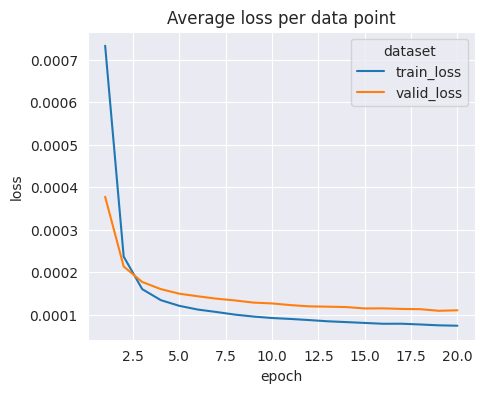

In [66]:
def plot_losses(train_loss, valid_loss):
  train_loss = np.array(train_loss)
  valid_loss = np.array(valid_loss)
  epoch = np.arange(1,len(train_loss)+1)
  data_wide = DataFrame({'epoch':epoch,'train_loss':train_loss,'valid_loss':valid_loss})
  data_long = melt(data_wide, ['epoch'], var_name = 'dataset', value_name = 'loss')
  fig,axis = plt.subplots( figsize = (5,4) )
  sns.lineplot( ax = axis, data = data_long, x = 'epoch', y = 'loss', hue = 'dataset')
  axis.set_title('Average loss per data point')

sns.set_style('darkgrid')
plot_losses(loss_train_list, loss_valid_list)